## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [1]:
# load the data if you need to; if you have already loaded the data, you may comment this cell out
# -- DO NOT CHANGE THIS CELL -- #
!mkdir /data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data

mkdir: cannot create directory ‘/data’: File exists
--2020-06-04 07:02:04--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.200.53
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.200.53|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338613624 (323M) [application/zip]
Saving to: ‘/data/train-test-data.zip.1’

train-test-data.zip 100%[===================>] 322.93M  80.9MB/s    in 4.1s    

2020-06-04 07:02:09 (78.9 MB/s) - ‘/data/train-test-data.zip.1’ saved [338613624/338613624]

Archive:  /data/train-test-data.zip


<div class="alert alert-info">**Note:** Workspaces automatically close connections after 30 minutes of inactivity (including inactivity while training!). Use the code snippet below to keep your workspace alive during training. (The active_session context manager is imported below.)
</div>
```
from workspace_utils import active_session

with active_session():
    train_model(num_epochs)
```


In [2]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# import utilities to keep workspaces alive during model training
from workspace_utils import active_session

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [3]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_dropout1): Dropout(p=0.25)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_dropout2): Dropout(p=0.25)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_dropout3): Dropout(p=0.25)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (maxpool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_dropout4): Dropout(p=0.25)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (maxpool5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_dropout5): Dropout(p=0.25)
  (fc6): Linear(in_features=12800, out_features=136, bias=True)
)


## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250), RandomCrop(224), Normalize(), ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [5]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains. Too large a batch size may cause your model to crash and/or run out of memory while training.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [6]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [7]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='/data/test_frames_keypoints.csv',
                                             root_dir='/data/test/',
                                             transform=data_transform)



In [8]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Wrap the image in a Variable, so that the net can process it as input and track how it changes as the image moves through the network.
3. Make sure the image is a FloatTensor, which the model expects.
4. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [9]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [10]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [11]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

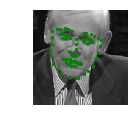

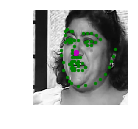

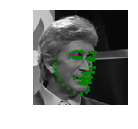

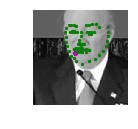

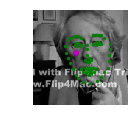

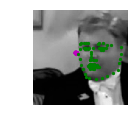

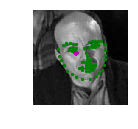

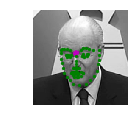

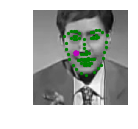

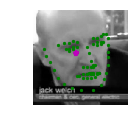

In [12]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [13]:
## TODO: Define the loss and optimization
import torch.optim as optim

criterion = nn.MSELoss()

optimizer = optim.Adam(net.parameters(), lr = 0.005)


## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [14]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0

    print('Finished Training')


In [22]:
# train your network
n_epochs = 20 # start small, and increase when you've decided on your model structure and hyperparams

# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
with active_session():
    train_net(n_epochs)

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1, Batch: 10, Avg. Loss: 0.15317994654178618
Epoch: 1, Batch: 20, Avg. Loss: 0.12192591950297356
Epoch: 1, Batch: 30, Avg. Loss: 0.13551899269223214
Epoch: 1, Batch: 40, Avg. Loss: 0.15402460917830468
Epoch: 1, Batch: 50, Avg. Loss: 0.13099730089306832
Epoch: 1, Batch: 60, Avg. Loss: 0.14902423098683357
Epoch: 1, Batch: 70, Avg. Loss: 0.14975314512848853
Epoch: 1, Batch: 80, Avg. Loss: 0.14642570540308952
Epoch: 1, Batch: 90, Avg. Loss: 0.14422793686389923
Epoch: 1, Batch: 100, Avg. Loss: 0.1443081721663475
Epoch: 1, Batch: 110, Avg. Loss: 0.14526984617114067
Epoch: 1, Batch: 120, Avg. Loss: 0.12708861529827117
Epoch: 1, Batch: 130, Avg. Loss: 0.18132244348526
Epoch: 1, Batch: 140, Avg. Loss: 0.14951179400086403
Epoch: 1, Batch: 150, Avg. Loss: 0.12428899481892586
Epoch: 1, Batch: 160, Avg. Loss: 0.15134653449058533
Epoch: 1, Batch: 170, Avg. Loss: 0.15453538969159125
Epoch: 1, Batch: 180, Avg. Loss: 0.18255126252770423
Epoch: 1, Batch: 190, Avg. Loss: 0.15537486523389815
Epoch:

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 2, Batch: 10, Avg. Loss: 0.13492528721690178
Epoch: 2, Batch: 20, Avg. Loss: 0.16747698187828064
Epoch: 2, Batch: 30, Avg. Loss: 0.12104267925024033
Epoch: 2, Batch: 40, Avg. Loss: 0.31991327702999117
Epoch: 2, Batch: 50, Avg. Loss: 0.16729221791028975
Epoch: 2, Batch: 60, Avg. Loss: 0.16271764561533927
Epoch: 2, Batch: 70, Avg. Loss: 0.1559439092874527
Epoch: 2, Batch: 80, Avg. Loss: 0.17676277831196785
Epoch: 2, Batch: 90, Avg. Loss: 0.14788194075226785
Epoch: 2, Batch: 100, Avg. Loss: 0.11895210891962052
Epoch: 2, Batch: 110, Avg. Loss: 0.14862437322735786
Epoch: 2, Batch: 120, Avg. Loss: 0.14584666006267072
Epoch: 2, Batch: 130, Avg. Loss: 0.15131110921502114
Epoch: 2, Batch: 140, Avg. Loss: 0.13589048013091087
Epoch: 2, Batch: 150, Avg. Loss: 0.1670842580497265
Epoch: 2, Batch: 160, Avg. Loss: 0.14848781377077103
Epoch: 2, Batch: 170, Avg. Loss: 0.19310977905988694
Epoch: 2, Batch: 180, Avg. Loss: 0.12997301407158374
Epoch: 2, Batch: 190, Avg. Loss: 0.10164867453277111
Epoc

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 3, Batch: 10, Avg. Loss: 0.13098801597952842
Epoch: 3, Batch: 20, Avg. Loss: 0.15818269178271294
Epoch: 3, Batch: 30, Avg. Loss: 0.11837716773152351
Epoch: 3, Batch: 40, Avg. Loss: 0.28031622245907784
Epoch: 3, Batch: 50, Avg. Loss: 0.13404228761792183
Epoch: 3, Batch: 60, Avg. Loss: 0.14223695248365403
Epoch: 3, Batch: 70, Avg. Loss: 0.15274802446365357
Epoch: 3, Batch: 80, Avg. Loss: 0.13048321902751922
Epoch: 3, Batch: 90, Avg. Loss: 0.1719159372150898
Epoch: 3, Batch: 100, Avg. Loss: 0.14442792311310768
Epoch: 3, Batch: 110, Avg. Loss: 0.12919604107737542
Epoch: 3, Batch: 120, Avg. Loss: 0.16141260862350465
Epoch: 3, Batch: 130, Avg. Loss: 0.2951016314327717
Epoch: 3, Batch: 140, Avg. Loss: 0.13467148840427398
Epoch: 3, Batch: 150, Avg. Loss: 0.14496360421180726
Epoch: 3, Batch: 160, Avg. Loss: 0.15840043723583222
Epoch: 3, Batch: 170, Avg. Loss: 0.10391665026545524
Epoch: 3, Batch: 180, Avg. Loss: 0.12517007067799568
Epoch: 3, Batch: 190, Avg. Loss: 0.13000860810279846
Epoc

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 4, Batch: 10, Avg. Loss: 0.15389452129602432
Epoch: 4, Batch: 20, Avg. Loss: 0.13014404028654097
Epoch: 4, Batch: 30, Avg. Loss: 0.13635656759142875
Epoch: 4, Batch: 40, Avg. Loss: 0.16174893081188202
Epoch: 4, Batch: 50, Avg. Loss: 0.11445566043257713
Epoch: 4, Batch: 60, Avg. Loss: 0.14291343912482263
Epoch: 4, Batch: 70, Avg. Loss: 0.1657329998910427
Epoch: 4, Batch: 80, Avg. Loss: 0.10713342987000943
Epoch: 4, Batch: 90, Avg. Loss: 0.13860062807798385
Epoch: 4, Batch: 100, Avg. Loss: 0.18877141252160073
Epoch: 4, Batch: 110, Avg. Loss: 0.1407574638724327
Epoch: 4, Batch: 120, Avg. Loss: 0.1683625414967537
Epoch: 4, Batch: 130, Avg. Loss: 0.1420517347753048
Epoch: 4, Batch: 140, Avg. Loss: 0.15517134889960288
Epoch: 4, Batch: 150, Avg. Loss: 0.13089537620544434
Epoch: 4, Batch: 160, Avg. Loss: 0.1650665406137705
Epoch: 4, Batch: 170, Avg. Loss: 0.15702907145023345
Epoch: 4, Batch: 180, Avg. Loss: 0.12950861155986787
Epoch: 4, Batch: 190, Avg. Loss: 0.109942115098238
Epoch: 4,

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 5, Batch: 10, Avg. Loss: 0.18336468786001206
Epoch: 5, Batch: 20, Avg. Loss: 0.1511099323630333
Epoch: 5, Batch: 30, Avg. Loss: 0.15509548485279084
Epoch: 5, Batch: 40, Avg. Loss: 0.2086169995367527
Epoch: 5, Batch: 50, Avg. Loss: 0.1467542015016079
Epoch: 5, Batch: 60, Avg. Loss: 0.1510929547250271
Epoch: 5, Batch: 70, Avg. Loss: 0.13038222566246987
Epoch: 5, Batch: 80, Avg. Loss: 0.14459248408675193
Epoch: 5, Batch: 90, Avg. Loss: 0.1462754376232624
Epoch: 5, Batch: 100, Avg. Loss: 0.12077399045228958
Epoch: 5, Batch: 110, Avg. Loss: 0.1519420251250267
Epoch: 5, Batch: 120, Avg. Loss: 0.17405909821391105
Epoch: 5, Batch: 130, Avg. Loss: 0.17742963060736655
Epoch: 5, Batch: 140, Avg. Loss: 0.15547756627202033
Epoch: 5, Batch: 150, Avg. Loss: 0.1451047033071518
Epoch: 5, Batch: 160, Avg. Loss: 0.1382339060306549
Epoch: 5, Batch: 170, Avg. Loss: 0.16988986507058143
Epoch: 5, Batch: 180, Avg. Loss: 0.12693490013480185
Epoch: 5, Batch: 190, Avg. Loss: 0.13621111288666726
Epoch: 5, 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 6, Batch: 10, Avg. Loss: 0.14190056435763837
Epoch: 6, Batch: 20, Avg. Loss: 0.15585207641124726
Epoch: 6, Batch: 30, Avg. Loss: 0.1030850786715746
Epoch: 6, Batch: 40, Avg. Loss: 0.1279366709291935
Epoch: 6, Batch: 50, Avg. Loss: 0.12727245688438416
Epoch: 6, Batch: 60, Avg. Loss: 0.19826361797749997
Epoch: 6, Batch: 70, Avg. Loss: 0.15298721343278884
Epoch: 6, Batch: 80, Avg. Loss: 0.17424879148602485
Epoch: 6, Batch: 90, Avg. Loss: 0.20874201133847237
Epoch: 6, Batch: 100, Avg. Loss: 0.13170755356550218
Epoch: 6, Batch: 110, Avg. Loss: 0.16030949130654334
Epoch: 6, Batch: 120, Avg. Loss: 0.13239353373646737
Epoch: 6, Batch: 130, Avg. Loss: 0.11849299296736718
Epoch: 6, Batch: 140, Avg. Loss: 0.1421264350414276
Epoch: 6, Batch: 150, Avg. Loss: 0.11724115759134293
Epoch: 6, Batch: 160, Avg. Loss: 0.15754536539316177
Epoch: 6, Batch: 170, Avg. Loss: 0.0932518795132637
Epoch: 6, Batch: 180, Avg. Loss: 0.1582108587026596
Epoch: 6, Batch: 190, Avg. Loss: 0.1520990539342165
Epoch: 6

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 7, Batch: 10, Avg. Loss: 0.15548123493790628
Epoch: 7, Batch: 20, Avg. Loss: 0.15663178339600564
Epoch: 7, Batch: 30, Avg. Loss: 0.09969994723796845
Epoch: 7, Batch: 40, Avg. Loss: 0.11524982154369354
Epoch: 7, Batch: 50, Avg. Loss: 0.13658740222454072
Epoch: 7, Batch: 60, Avg. Loss: 0.1532142460346222
Epoch: 7, Batch: 70, Avg. Loss: 0.1724613830447197
Epoch: 7, Batch: 80, Avg. Loss: 0.19294021427631378
Epoch: 7, Batch: 90, Avg. Loss: 0.22208441346883773
Epoch: 7, Batch: 100, Avg. Loss: 0.15269426107406617
Epoch: 7, Batch: 110, Avg. Loss: 0.2328393951058388
Epoch: 7, Batch: 120, Avg. Loss: 0.13468421325087548
Epoch: 7, Batch: 130, Avg. Loss: 0.1794760011136532
Epoch: 7, Batch: 140, Avg. Loss: 0.1666405454277992
Epoch: 7, Batch: 150, Avg. Loss: 0.17685473784804345
Epoch: 7, Batch: 160, Avg. Loss: 0.13298822268843652
Epoch: 7, Batch: 170, Avg. Loss: 0.17936753630638122
Epoch: 7, Batch: 180, Avg. Loss: 0.09901111796498299
Epoch: 7, Batch: 190, Avg. Loss: 0.10971161797642708
Epoch: 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 8, Batch: 10, Avg. Loss: 0.11664754673838615
Epoch: 8, Batch: 20, Avg. Loss: 0.12015436217188835
Epoch: 8, Batch: 30, Avg. Loss: 0.19221800863742827
Epoch: 8, Batch: 40, Avg. Loss: 0.14671798273921013
Epoch: 8, Batch: 50, Avg. Loss: 0.1420004852116108
Epoch: 8, Batch: 60, Avg. Loss: 0.20430248975753784
Epoch: 8, Batch: 70, Avg. Loss: 0.24028452411293982
Epoch: 8, Batch: 80, Avg. Loss: 0.18921512886881828
Epoch: 8, Batch: 90, Avg. Loss: 0.19563788771629334
Epoch: 8, Batch: 100, Avg. Loss: 0.18217552453279495
Epoch: 8, Batch: 110, Avg. Loss: 0.23548855483531952
Epoch: 8, Batch: 120, Avg. Loss: 0.1327478840947151
Epoch: 8, Batch: 130, Avg. Loss: 0.1153582826256752
Epoch: 8, Batch: 140, Avg. Loss: 0.15758507400751115
Epoch: 8, Batch: 150, Avg. Loss: 0.1604007862508297
Epoch: 8, Batch: 160, Avg. Loss: 0.16657392606139182
Epoch: 8, Batch: 170, Avg. Loss: 0.14993708468973638
Epoch: 8, Batch: 180, Avg. Loss: 0.11612632349133492
Epoch: 8, Batch: 190, Avg. Loss: 0.1130191668868065
Epoch: 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 9, Batch: 10, Avg. Loss: 0.186381509155035
Epoch: 9, Batch: 20, Avg. Loss: 0.15420460999011992
Epoch: 9, Batch: 30, Avg. Loss: 0.13091353476047515
Epoch: 9, Batch: 40, Avg. Loss: 0.310056035220623
Epoch: 9, Batch: 50, Avg. Loss: 0.14077498987317086
Epoch: 9, Batch: 60, Avg. Loss: 0.16762659922242165
Epoch: 9, Batch: 70, Avg. Loss: 0.1765884831547737
Epoch: 9, Batch: 80, Avg. Loss: 0.20351578146219254
Epoch: 9, Batch: 90, Avg. Loss: 0.1514362558722496
Epoch: 9, Batch: 100, Avg. Loss: 0.13440337628126145
Epoch: 9, Batch: 110, Avg. Loss: 0.1716453269124031
Epoch: 9, Batch: 120, Avg. Loss: 0.14421590715646743
Epoch: 9, Batch: 130, Avg. Loss: 0.14518985226750375
Epoch: 9, Batch: 140, Avg. Loss: 0.19464056864380835
Epoch: 9, Batch: 150, Avg. Loss: 0.146227103471756
Epoch: 9, Batch: 160, Avg. Loss: 0.17875817865133287
Epoch: 9, Batch: 170, Avg. Loss: 0.18865872621536256
Epoch: 9, Batch: 180, Avg. Loss: 0.12474765740334988
Epoch: 9, Batch: 190, Avg. Loss: 0.15049820840358735
Epoch: 9, B

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 10, Batch: 10, Avg. Loss: 0.17168715670704843
Epoch: 10, Batch: 20, Avg. Loss: 0.14541365057229996
Epoch: 10, Batch: 30, Avg. Loss: 0.125456565618515
Epoch: 10, Batch: 40, Avg. Loss: 0.1913760866969824
Epoch: 10, Batch: 50, Avg. Loss: 0.13760827630758285
Epoch: 10, Batch: 60, Avg. Loss: 0.1526803381741047
Epoch: 10, Batch: 70, Avg. Loss: 0.14179777055978776
Epoch: 10, Batch: 80, Avg. Loss: 0.15417234674096109
Epoch: 10, Batch: 90, Avg. Loss: 0.20433229357004165
Epoch: 10, Batch: 100, Avg. Loss: 0.18483564704656602
Epoch: 10, Batch: 110, Avg. Loss: 0.1659789726138115
Epoch: 10, Batch: 120, Avg. Loss: 0.1520458698272705
Epoch: 10, Batch: 130, Avg. Loss: 0.1415027640759945
Epoch: 10, Batch: 140, Avg. Loss: 0.22387209981679917
Epoch: 10, Batch: 150, Avg. Loss: 0.11631483770906925
Epoch: 10, Batch: 160, Avg. Loss: 0.14597435295581818
Epoch: 10, Batch: 170, Avg. Loss: 0.14074427783489227
Epoch: 10, Batch: 180, Avg. Loss: 0.12661566436290742
Epoch: 10, Batch: 190, Avg. Loss: 0.14585997

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 11, Batch: 10, Avg. Loss: 0.1417981915175915
Epoch: 11, Batch: 20, Avg. Loss: 0.11848799958825111
Epoch: 11, Batch: 30, Avg. Loss: 0.13650740087032318
Epoch: 11, Batch: 40, Avg. Loss: 0.13640591204166413
Epoch: 11, Batch: 50, Avg. Loss: 0.1465023934841156
Epoch: 11, Batch: 60, Avg. Loss: 0.32687910422682764
Epoch: 11, Batch: 70, Avg. Loss: 0.13847726956009865
Epoch: 11, Batch: 80, Avg. Loss: 0.14891429394483566
Epoch: 11, Batch: 90, Avg. Loss: 0.21602622643113137
Epoch: 11, Batch: 100, Avg. Loss: 0.16876736134290696
Epoch: 11, Batch: 110, Avg. Loss: 0.15180360972881318
Epoch: 11, Batch: 120, Avg. Loss: 0.2357806906104088
Epoch: 11, Batch: 130, Avg. Loss: 0.12377031147480011
Epoch: 11, Batch: 140, Avg. Loss: 0.1744626559317112
Epoch: 11, Batch: 150, Avg. Loss: 0.123925319314003
Epoch: 11, Batch: 160, Avg. Loss: 0.1871175266802311
Epoch: 11, Batch: 170, Avg. Loss: 0.16390417739748955
Epoch: 11, Batch: 180, Avg. Loss: 0.14103117436170579
Epoch: 11, Batch: 190, Avg. Loss: 0.15294300

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 12, Batch: 10, Avg. Loss: 0.14825742170214654
Epoch: 12, Batch: 20, Avg. Loss: 0.15086951330304146
Epoch: 12, Batch: 30, Avg. Loss: 0.19785701036453246
Epoch: 12, Batch: 40, Avg. Loss: 0.15058309584856033
Epoch: 12, Batch: 50, Avg. Loss: 0.19326212182641028
Epoch: 12, Batch: 60, Avg. Loss: 0.12181721553206444
Epoch: 12, Batch: 70, Avg. Loss: 0.11341123804450035
Epoch: 12, Batch: 80, Avg. Loss: 0.17563515678048133
Epoch: 12, Batch: 90, Avg. Loss: 0.1459457643330097
Epoch: 12, Batch: 100, Avg. Loss: 0.1731554701924324
Epoch: 12, Batch: 110, Avg. Loss: 0.1704855114221573
Epoch: 12, Batch: 120, Avg. Loss: 0.1334226567298174
Epoch: 12, Batch: 130, Avg. Loss: 0.15931097492575647
Epoch: 12, Batch: 140, Avg. Loss: 0.17287157326936722
Epoch: 12, Batch: 150, Avg. Loss: 0.0955623134970665
Epoch: 12, Batch: 160, Avg. Loss: 0.13970073014497758
Epoch: 12, Batch: 170, Avg. Loss: 0.19051993116736413
Epoch: 12, Batch: 180, Avg. Loss: 0.10813232585787773
Epoch: 12, Batch: 190, Avg. Loss: 0.138846

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 13, Batch: 10, Avg. Loss: 0.1754386730492115
Epoch: 13, Batch: 20, Avg. Loss: 0.14507535323500634
Epoch: 13, Batch: 30, Avg. Loss: 0.15081551000475885
Epoch: 13, Batch: 40, Avg. Loss: 0.15676755234599113
Epoch: 13, Batch: 50, Avg. Loss: 0.12344831302762031
Epoch: 13, Batch: 60, Avg. Loss: 0.16917350143194199
Epoch: 13, Batch: 70, Avg. Loss: 0.15212575644254683
Epoch: 13, Batch: 80, Avg. Loss: 0.14539405703544617
Epoch: 13, Batch: 90, Avg. Loss: 0.1484595388174057
Epoch: 13, Batch: 100, Avg. Loss: 0.14524000212550164
Epoch: 13, Batch: 110, Avg. Loss: 0.16909967362880707
Epoch: 13, Batch: 120, Avg. Loss: 0.15411582067608834
Epoch: 13, Batch: 130, Avg. Loss: 0.14505673088133336
Epoch: 13, Batch: 140, Avg. Loss: 0.11700900420546531
Epoch: 13, Batch: 150, Avg. Loss: 0.13663826286792755
Epoch: 13, Batch: 160, Avg. Loss: 0.12442091777920723
Epoch: 13, Batch: 170, Avg. Loss: 0.13095791190862655
Epoch: 13, Batch: 180, Avg. Loss: 0.14016079530119896
Epoch: 13, Batch: 190, Avg. Loss: 0.120

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 14, Batch: 10, Avg. Loss: 0.1482482559978962
Epoch: 14, Batch: 20, Avg. Loss: 0.1480121597647667
Epoch: 14, Batch: 30, Avg. Loss: 0.34816723242402076
Epoch: 14, Batch: 40, Avg. Loss: 0.17858490720391273
Epoch: 14, Batch: 50, Avg. Loss: 0.12560226172208785
Epoch: 14, Batch: 60, Avg. Loss: 0.1351153552532196
Epoch: 14, Batch: 70, Avg. Loss: 0.10939808413386345
Epoch: 14, Batch: 80, Avg. Loss: 0.16436629444360734
Epoch: 14, Batch: 90, Avg. Loss: 0.2002251997590065
Epoch: 14, Batch: 100, Avg. Loss: 0.2129371054470539
Epoch: 14, Batch: 110, Avg. Loss: 0.1399947464466095
Epoch: 14, Batch: 120, Avg. Loss: 0.1719013348221779
Epoch: 14, Batch: 130, Avg. Loss: 0.16761478930711746
Epoch: 14, Batch: 140, Avg. Loss: 0.17708467543125153
Epoch: 14, Batch: 150, Avg. Loss: 0.14910055994987487
Epoch: 14, Batch: 160, Avg. Loss: 0.13437423184514047
Epoch: 14, Batch: 170, Avg. Loss: 0.1301089882850647
Epoch: 14, Batch: 180, Avg. Loss: 0.204727004468441
Epoch: 14, Batch: 190, Avg. Loss: 0.13034475669

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 15, Batch: 10, Avg. Loss: 0.13298020884394646
Epoch: 15, Batch: 20, Avg. Loss: 0.15816703923046588
Epoch: 15, Batch: 30, Avg. Loss: 0.1399407610297203
Epoch: 15, Batch: 40, Avg. Loss: 0.11787869930267333
Epoch: 15, Batch: 50, Avg. Loss: 0.13875514194369315
Epoch: 15, Batch: 60, Avg. Loss: 0.16876611933112146
Epoch: 15, Batch: 70, Avg. Loss: 0.14024780169129372
Epoch: 15, Batch: 80, Avg. Loss: 0.15810492113232613
Epoch: 15, Batch: 90, Avg. Loss: 0.19156381860375404
Epoch: 15, Batch: 100, Avg. Loss: 0.2946255847811699
Epoch: 15, Batch: 110, Avg. Loss: 0.15696133449673652
Epoch: 15, Batch: 120, Avg. Loss: 0.13802166953682898
Epoch: 15, Batch: 130, Avg. Loss: 0.16278220936656
Epoch: 15, Batch: 140, Avg. Loss: 0.1454623632133007
Epoch: 15, Batch: 150, Avg. Loss: 0.20141986943781376
Epoch: 15, Batch: 160, Avg. Loss: 0.1858741894364357
Epoch: 15, Batch: 170, Avg. Loss: 0.14167866595089434
Epoch: 15, Batch: 180, Avg. Loss: 0.11250263601541519
Epoch: 15, Batch: 190, Avg. Loss: 0.11375067

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 16, Batch: 10, Avg. Loss: 0.12232822701334953
Epoch: 16, Batch: 20, Avg. Loss: 0.1187193289399147
Epoch: 16, Batch: 30, Avg. Loss: 0.12976348251104355
Epoch: 16, Batch: 40, Avg. Loss: 0.2802841514348984
Epoch: 16, Batch: 50, Avg. Loss: 0.1334640711545944
Epoch: 16, Batch: 60, Avg. Loss: 0.20401742830872535
Epoch: 16, Batch: 70, Avg. Loss: 0.1298648849129677
Epoch: 16, Batch: 80, Avg. Loss: 0.16558515131473542
Epoch: 16, Batch: 90, Avg. Loss: 0.11907878890633583
Epoch: 16, Batch: 100, Avg. Loss: 0.14960050582885742
Epoch: 16, Batch: 110, Avg. Loss: 0.1804095610976219
Epoch: 16, Batch: 120, Avg. Loss: 0.1363081306219101
Epoch: 16, Batch: 130, Avg. Loss: 0.14276231676340104
Epoch: 16, Batch: 140, Avg. Loss: 0.1923881284892559
Epoch: 16, Batch: 150, Avg. Loss: 0.12266666516661644
Epoch: 16, Batch: 160, Avg. Loss: 0.1653820037841797
Epoch: 16, Batch: 170, Avg. Loss: 0.16428878009319306
Epoch: 16, Batch: 180, Avg. Loss: 0.15430533811450003
Epoch: 16, Batch: 190, Avg. Loss: 0.121867355

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 17, Batch: 10, Avg. Loss: 0.1316794253885746
Epoch: 17, Batch: 20, Avg. Loss: 0.15389522314071655
Epoch: 17, Batch: 30, Avg. Loss: 0.13698229007422924
Epoch: 17, Batch: 40, Avg. Loss: 0.1351197436451912
Epoch: 17, Batch: 50, Avg. Loss: 0.18278446644544602
Epoch: 17, Batch: 60, Avg. Loss: 0.15936279371380807
Epoch: 17, Batch: 70, Avg. Loss: 0.12782425805926323
Epoch: 17, Batch: 80, Avg. Loss: 0.1789184592664242
Epoch: 17, Batch: 90, Avg. Loss: 0.12323659658432007
Epoch: 17, Batch: 100, Avg. Loss: 0.160818649828434
Epoch: 17, Batch: 110, Avg. Loss: 0.1559208743274212
Epoch: 17, Batch: 120, Avg. Loss: 0.17178465500473977
Epoch: 17, Batch: 130, Avg. Loss: 0.19936683624982834
Epoch: 17, Batch: 140, Avg. Loss: 0.13093890026211738
Epoch: 17, Batch: 150, Avg. Loss: 0.16370189487934111
Epoch: 17, Batch: 160, Avg. Loss: 0.18816461265087128
Epoch: 17, Batch: 170, Avg. Loss: 0.12756674662232398
Epoch: 17, Batch: 180, Avg. Loss: 0.12137922272086143
Epoch: 17, Batch: 190, Avg. Loss: 0.1514261

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 18, Batch: 10, Avg. Loss: 0.14373071864247322
Epoch: 18, Batch: 20, Avg. Loss: 0.16220116019248962
Epoch: 18, Batch: 30, Avg. Loss: 0.11957570835947991
Epoch: 18, Batch: 40, Avg. Loss: 0.14990996792912484
Epoch: 18, Batch: 50, Avg. Loss: 0.16774192899465562
Epoch: 18, Batch: 60, Avg. Loss: 0.15488059893250467
Epoch: 18, Batch: 70, Avg. Loss: 0.12983993217349052
Epoch: 18, Batch: 80, Avg. Loss: 0.11723504588007927
Epoch: 18, Batch: 90, Avg. Loss: 0.15826935768127443
Epoch: 18, Batch: 100, Avg. Loss: 0.1428470253944397
Epoch: 18, Batch: 110, Avg. Loss: 0.24694961830973625
Epoch: 18, Batch: 120, Avg. Loss: 0.10927976742386818
Epoch: 18, Batch: 130, Avg. Loss: 0.19205086380243303
Epoch: 18, Batch: 140, Avg. Loss: 0.16476385444402694
Epoch: 18, Batch: 150, Avg. Loss: 0.10601224899291992
Epoch: 18, Batch: 160, Avg. Loss: 0.14536315202713013
Epoch: 18, Batch: 170, Avg. Loss: 0.1346753478050232
Epoch: 18, Batch: 180, Avg. Loss: 0.16424831598997117
Epoch: 18, Batch: 190, Avg. Loss: 0.164

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 19, Batch: 10, Avg. Loss: 0.13054056987166404
Epoch: 19, Batch: 20, Avg. Loss: 0.12854636013507842
Epoch: 19, Batch: 30, Avg. Loss: 0.14035639688372611
Epoch: 19, Batch: 40, Avg. Loss: 0.11927414909005166
Epoch: 19, Batch: 50, Avg. Loss: 0.1680402636528015
Epoch: 19, Batch: 60, Avg. Loss: 0.1877191908657551
Epoch: 19, Batch: 70, Avg. Loss: 0.1444719709455967
Epoch: 19, Batch: 80, Avg. Loss: 0.16328135952353479
Epoch: 19, Batch: 90, Avg. Loss: 0.1791459307074547
Epoch: 19, Batch: 100, Avg. Loss: 0.1390713058412075
Epoch: 19, Batch: 110, Avg. Loss: 0.13420030251145362
Epoch: 19, Batch: 120, Avg. Loss: 0.14413902163505554
Epoch: 19, Batch: 130, Avg. Loss: 0.17436352148652076
Epoch: 19, Batch: 140, Avg. Loss: 0.13469364494085312
Epoch: 19, Batch: 150, Avg. Loss: 0.13762952536344528
Epoch: 19, Batch: 160, Avg. Loss: 0.1284088283777237
Epoch: 19, Batch: 170, Avg. Loss: 0.15006768256425856
Epoch: 19, Batch: 180, Avg. Loss: 0.1886093132197857
Epoch: 19, Batch: 190, Avg. Loss: 0.13308870

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 20, Batch: 10, Avg. Loss: 0.14975170865654946
Epoch: 20, Batch: 20, Avg. Loss: 0.1748166188597679
Epoch: 20, Batch: 30, Avg. Loss: 0.13424863256514072
Epoch: 20, Batch: 40, Avg. Loss: 0.16105307266116142
Epoch: 20, Batch: 50, Avg. Loss: 0.15474894344806672
Epoch: 20, Batch: 60, Avg. Loss: 0.15780405178666115
Epoch: 20, Batch: 70, Avg. Loss: 0.21341491490602493
Epoch: 20, Batch: 80, Avg. Loss: 0.23140023201704024
Epoch: 20, Batch: 90, Avg. Loss: 0.14386575818061828
Epoch: 20, Batch: 100, Avg. Loss: 0.17086056545376777
Epoch: 20, Batch: 110, Avg. Loss: 0.1371657855808735
Epoch: 20, Batch: 120, Avg. Loss: 0.1244241863489151
Epoch: 20, Batch: 130, Avg. Loss: 0.16718055680394173
Epoch: 20, Batch: 140, Avg. Loss: 0.14388513825833799
Epoch: 20, Batch: 150, Avg. Loss: 0.14822098314762117
Epoch: 20, Batch: 160, Avg. Loss: 0.14915597662329674
Epoch: 20, Batch: 170, Avg. Loss: 0.1323150098323822
Epoch: 20, Batch: 180, Avg. Loss: 0.1571045570075512
Epoch: 20, Batch: 190, Avg. Loss: 0.130409

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [23]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


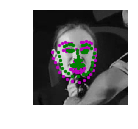

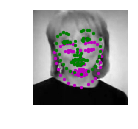

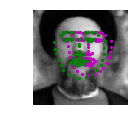

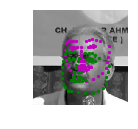

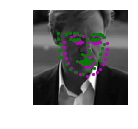

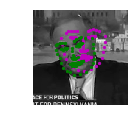

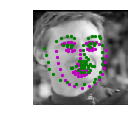

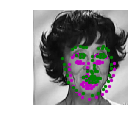

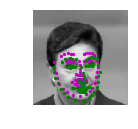

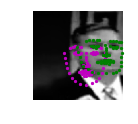

In [24]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

# visualize_output(test_images, test_outputs, gt_pts)
visualize_output(test_images, test_outputs, gt_pts)

Once you've found a good model (or two), save your model so you can load it and use it later!

Save your models but please **delete any checkpoints and saved models before you submit your project** otherwise your workspace may be too large to submit.

In [25]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_1.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: 

I chose MSELoss which measure the mean squared error (squared L2 norm) between each element in the input and target because it is a good measure of the Euclidean distance between points. If the MSE would be 0 it would mean that the model was trained perfecly with 0 error. And I for optimisation I used Adam Optimizer because it was mentioned in the referenced paper. I set the hyperparameter learning rate (lr) to 0.005. 

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**:
I started with a general recommended architecture with only two - three CNN but later I increased the number of CNN to five. To prevent overfitting the data, I added maxPooling after each convolutional layer and dropout layer with 25% dropout rate.

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**:
I started testing my architecture with small number of epochs raning between 5-10 with default batch size of 10. After finding a good architecture I run the model in 30 epochs.

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[-0.27701297 -0.35900918 -0.27111956 -0.2376059  -0.35075566]
 [-0.26330587 -0.3847926  -0.18032521 -0.1874007  -0.24087895]
 [-0.04732492 -0.34004906 -0.23911437 -0.27866557 -0.15350266]
 [-0.27467409 -0.04100093 -0.29902977 -0.16526052 -0.13507184]
 [-0.3636727  -0.12003192 -0.37820372 -0.19307515 -0.39178461]]
(5, 5)


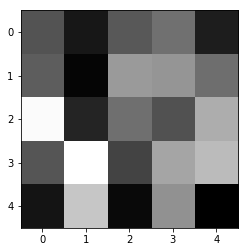

In [26]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

(224, 224)


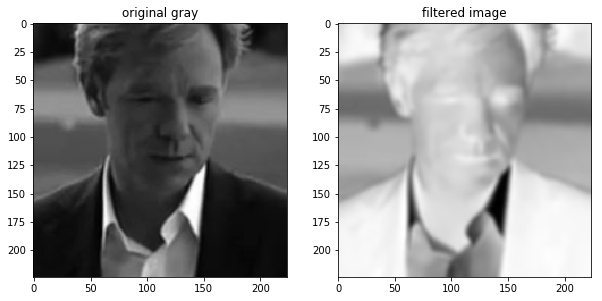

In [27]:
##TODO: load in and display any image from the transformed test dataset

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image
import cv2
%matplotlib inline

imgNo= 4

myImage = np.squeeze(test_images[imgNo].data)
myImage = myImage.numpy()  
print(myImage.shape)

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image

myFilter=w[filter_index][0]
filtered_image = cv2.filter2D(myImage, -1, myFilter)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('original gray')
ax1.imshow(myImage, cmap='gray')

ax2.set_title('filtered image')
ax2.imshow(filtered_image, cmap='gray')

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: (does it detect vertical lines or does it blur out noise, etc.) 

When I compared how the original image and the filtered image look: the filtered image is less sharp and is with less sharp edges. I concluded that the filter has the blurring (smoothing) effect.

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!